In [ ]:
%cd '/content/drive/MyDrive/ecehw/project'

/content/drive/MyDrive/ecehw/project


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

from resnet import ResNet18, MLP, Block

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [ ]:
BATCH_SIZE = 256

trainset = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size = BATCH_SIZE, shuffle=True, )

testset = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size = BATCH_SIZE, shuffle=True, )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
def get_color_distortion(s:float=0.5):
    """
    Function from the paper that create color distortion 
    s: float, the strength of color distortion, for CIFAR 10, the paper use 0.5
    """
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort

In [ ]:
train_transform = transforms.Compose([
            # make sure we're using PIL instead of tensor when doing other transform 
            transforms.ToPILImage(),
            #transforms.GaussianBlur(23, sigma=(0.1, 2.0)), # CIFAR 10 doesn't use gaussian blur
            transforms.RandomResizedCrop(size=32,scale=(0.08,0.1),ratio=(0.75,1.33)),
            transforms.RandomHorizontalFlip(p=0.5),
            get_color_distortion(),
            transforms.ToTensor(),
            # the normalize numbers are from previous assignment
            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

linear_eval_transform = transforms.Compose([
            #transforms.GaussianBlur(23, sigma=(0.1, 2.0)), # CIFAR 10 doesn't use gaussian blur
            transforms.RandomResizedCrop(size=32,scale=(0.08,0.1),ratio=(0.75,1.33)),
            transforms.RandomHorizontalFlip(p=0.5),
            get_color_distortion(),
            transforms.ToTensor(),
            # the normalize numbers are from previous assignment
            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

linear_eval_transform_test = transforms.Compose([
            #transforms.GaussianBlur(23, sigma=(0.1, 2.0)), # CIFAR 10 doesn't use gaussian blur
            transforms.RandomResizedCrop(size=32,scale=(0.08,0.1),ratio=(0.75,1.33)),
            transforms.ToTensor(),
            # the normalize numbers are from previous assignment
            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

In [ ]:
net_f = ResNet18(3, Block)
net_g = MLP(512)
net = nn.Sequential(net_f, net_g)
optimizer = optim.Adam(net.parameters(), lr=0.0003*(BATCH_SIZE / 256), weight_decay=1e-4)
# optimizer = optim.SGD(net.parameters(), lr=0.3*(BATCH_SIZE / 256), weight_decay=1e-6)
# optimizer = optim.SGD(net.parameters(), lr=LR, weight_decay=1e-6)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(trainset))
net.to(device)
net.train()

Sequential(
  (0): ResNet18(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): Block(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (identity): Sequential()
      )
      (1): Block(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [ ]:
def compute_loss(yhat, t):
    """
    Computing the contrastive loss based on cosine similarity
    input:
        yhat: [tensor] latent embedding features size: BATCH_SIZE * 128
        t: [float] temperature range: (0.0, 1.0)
    output:
        loss: [tensor] 1D
    """
    
    # testing code
    #from collections import defaultdict
    #cache = defaultdict(int)
    #for i in range(yhat.shape[0]):
    #    for j in range(i+1, yhat.shape[0]):
    #        val = torch.nn.functional.cosine_similarity(yhat[i], yhat[j], dim=0, eps=1e-8)
    #        cache[(i, j)] = val
    #        cache[(j, i)] = val
    
    N = yhat.shape[0]

    # Calculate the pair-wise consine similarity
    cache = torch.nn.functional.cosine_similarity(yhat.unsqueeze(0), yhat.unsqueeze(1), dim=-1, eps=1e-8)
    cache = cache / t
    
    # Delete the diagonal entries
    mask = torch.eye(N, dtype=bool)
    cache = cache[~mask].view((N, N-1))

    # Make pesudo-labels
    label = []
    for i in range(N // 2):
        label.append(int(2 *i))
        label.append(int(2 *i))
    label = torch.tensor(label)
    label = label.to(device)

    # Calculate the cross entropy loss
    loss = F.cross_entropy(cache, label)

    return loss
    

    """
    # Calculate the pair-wise consine similarity
    cache = torch.nn.functional.cosine_similarity(yhat.unsqueeze(0), yhat.unsqueeze(1), dim=-1, eps=1e-8)
    # print(cache)
    cache = torch.exp(cache / t)
    cache_sum = torch.sum(cache, dim=1)

    
    # Compute the contrastive loss
    loss = 0
    for n in range(yhat.shape[0]):
        # Get the index of positive pairs, based on 2 tensors of the same pair are adjacent in terms of index
        i = n
        if i % 2 == 0:
            j = i + 1
        else:
            j = i - 1

        # The numerator is between the positive pair
        # The denominator is between one tensor with all OTHER tensors
        numerator = cache[i, j]
        denominator = cache_sum[i] - cache[i, i]
        #denominator = 0
        #for k in range(yhat.shape[0]):
        #    if k != i:
        #        denominator += cache[i, k]
        cur_loss = (-1) * torch.log(numerator / denominator)
        # Add up the loss and take the average
        loss += (1 / (2 * yhat.shape[0])) * cur_loss
    loss = torch.tensor(loss.item())
    loss.requires_grad = True
    # loss = torch.mean(loss)
    
    return loss
    """

In [ ]:
# loop through each batch in trainset 
LOSSES = []
EPOCHS = 200
OPTIM_LOSS = float('inf')

for epoch in range(EPOCHS):
    cost = 0
    for data, label in trainset:
        for ind_img in range(len(data)): # loop through each image in batch 
            par_tensor = data[ind_img]
            cur_tensor_0 = train_transform(par_tensor) # first aug
            cur_tensor_1 = train_transform(par_tensor) # second aug 
            # resize 
            cur_tensor_0, cur_tensor_1 = torch.unsqueeze(cur_tensor_0, 0), torch.unsqueeze(cur_tensor_1, 0) 
            # if this is the first image in the batch, we just concat the 2 data aug 
            if ind_img == 0:
                total_tensor = torch.cat((cur_tensor_0, cur_tensor_1), dim=0)
            # else append to the previous augmented pair in the batch 
            else:
                total_tensor = torch.cat((total_tensor, cur_tensor_0, cur_tensor_1), dim=0)
            
        total_tensor = total_tensor.to(device)
        # pass <total_tensor> into the model 
        yhat = net(total_tensor)
        # calculate loss 
        # loss = compute_loss(yhat, 0.5)
        loss = compute_loss(yhat, 0.07)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        cost += loss.item()

    avg_loss = cost / len(trainset)
    LOSSES.append(avg_loss)
    if avg_loss < OPTIM_LOSS:
        OPTIM_LOSS = avg_loss
        torch.save(net.state_dict(), 'simclr.pt')
        torch.save(net_f.state_dict(), 'simclr_netf.pt')
    print("Epoch: {}, Average Contrastive Loss {:f}".format(epoch, avg_loss))
        

Epoch: 0, Average Contrastive Loss 5.820658
Epoch: 1, Average Contrastive Loss 5.721632
Epoch: 2, Average Contrastive Loss 5.594156
Epoch: 3, Average Contrastive Loss 5.509527
Epoch: 4, Average Contrastive Loss 5.414582
Epoch: 5, Average Contrastive Loss 5.338105
Epoch: 6, Average Contrastive Loss 5.274501
Epoch: 7, Average Contrastive Loss 5.203047
Epoch: 8, Average Contrastive Loss 5.160844
Epoch: 9, Average Contrastive Loss 5.092528
Epoch: 10, Average Contrastive Loss 5.058919
Epoch: 11, Average Contrastive Loss 4.985517
Epoch: 12, Average Contrastive Loss 4.946435
Epoch: 13, Average Contrastive Loss 4.875840
Epoch: 14, Average Contrastive Loss 4.859717
Epoch: 15, Average Contrastive Loss 4.802228
Epoch: 16, Average Contrastive Loss 4.776885
Epoch: 17, Average Contrastive Loss 4.703448
Epoch: 18, Average Contrastive Loss 4.699400
Epoch: 19, Average Contrastive Loss 4.628539
Epoch: 20, Average Contrastive Loss 4.624438
Epoch: 21, Average Contrastive Loss 4.580088
Epoch: 22, Average C

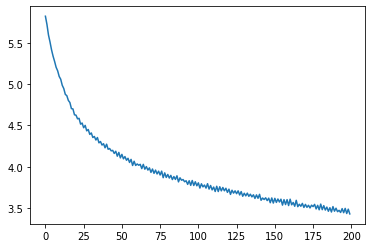

In [ ]:
plt.plot([_ for _ in range(len(LOSSES))], LOSSES)

In [ ]:
print(LOSSES)

[5.820658277492134, 5.721632327352252, 5.594156133885286, 5.509526573881811, 5.414581688082948, 5.338105442572613, 5.274500557354519, 5.203046572451689, 5.160844401437409, 5.092527671736114, 5.058918698709839, 4.985517338830597, 4.946435492865893, 4.875840437655547, 4.85971705645931, 4.802227599280221, 4.776885053332971, 4.70344833938443, 4.6994004869947625, 4.628538919954884, 4.624437997535783, 4.580087858803418, 4.585887542792729, 4.515331382654151, 4.529028286739272, 4.472160650759327, 4.5004222368707465, 4.434369194264314, 4.450937279633114, 4.391415692105586, 4.409221734319415, 4.354030645623499, 4.366388724774731, 4.323465159961155, 4.353477543714095, 4.289314992573797, 4.305372899892379, 4.262760090584657, 4.278750838065634, 4.2294658154857405, 4.272970109569783, 4.2117926441893285, 4.220666612897601, 4.19227632089537, 4.198292414752805, 4.1611045781446965, 4.187467697931796, 4.127982486267479, 4.173739203384945, 4.107520794381901, 4.149846331197388, 4.0960886137826105, 4.123488

In [ ]:
print("{} epochs in total.".format(len(LOSSES)))

200 epochs in total.


In [ ]:
torch.save(net.state_dict(), 'simclr_last_epoch.pt')
torch.save(net_f.state_dict(), 'simclr_netf_last_epoch.pt')

In [ ]:
# decide the learning rate, whether to implement lr decay
# linear eval (discard net_g, connect net_f with logistic regressor, freeze net_f, train the whole net)
# supervised counterpart, for simCLR epoch=90
# write the report

### Linear Evaluation

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, in_c):
      super(LogisticRegression, self).__init__()
      
      self.linear = nn.Linear(in_c, 10)

    def forward(self, x):
      out = x.view(x.size(0), -1)
      out = self.linear(out)
      # out = F.softmax(out, dim=1)
      return out

In [ ]:
net_f = ResNet18(3, Block)
# net_f.load_state_dict(torch.load("simclr_netf_last_epoch.pt"))
net_g = MLP(512)
net = nn.Sequential(net_f, net_g)
net.load_state_dict(torch.load("simclr_last_epoch.pt"))
net_f.eval()
for parameter in net_f.parameters():
    parameter.requires_grad = False

lr = LogisticRegression(512)
lr.train()

net_eval = nn.Sequential(net_f, lr)

In [ ]:
BATCH_SIZE = 256

optimizer = optim.Adam(net_eval.parameters(), lr=0.001*(BATCH_SIZE / 256), weight_decay=1e-4)
net_eval.to(device)

Sequential(
  (0): ResNet18(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): Block(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (identity): Sequential()
      )
      (1): Block(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [ ]:
trainset = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True, transform=linear_eval_transform),
    batch_size = BATCH_SIZE, shuffle=True, )

testset = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, download=True, transform=linear_eval_transform_test),
    batch_size = BATCH_SIZE, shuffle=True, )

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# loop through each batch in trainset 
LOSSES_TRAIN, LOSSES_EVAL = [], []
TEST_ACC = []
EPOCHS = 30
OPTIM_LOSS = float('inf')

for epoch in range(EPOCHS):
    cost = 0
    lr.train()
    for data, label in trainset:
        data, label = data.to(device), label.to(device)
        yhat = net_eval(data)
        # calculate loss 
        loss = F.cross_entropy(yhat, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()
        cost += loss.item()

    avg_loss_train = cost / len(trainset)
    LOSSES_TRAIN.append(avg_loss_train)

    lr.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for data, label in testset:
            data, label = data.to(device), label.to(device)
            y_pred = net_eval(data)
            # calculate loss 
            loss = F.cross_entropy(y_pred, label)
            cost += loss.item()

            total += len(label)
            y_hat = torch.argmax(y_pred, dim=1)
            correct += torch.sum(torch.eq(y_hat, label)).item()

    avg_loss_test = cost / len(testset)
    LOSSES_EVAL.append(avg_loss_test)

    test_accuracy = correct / total
    TEST_ACC.append(test_accuracy)

    print("Epoch: {}; TRAIN LOSS: {:f}; TEST LOSS: {:f}; TEST ACC: {:f}".format(epoch, avg_loss_train, avg_loss_test, test_accuracy))
    

Epoch: 0; TRAIN LOSS: 2.105921; TEST LOSS: 12.327968; TEST ACC: 0.491100
Epoch: 1; TRAIN LOSS: 2.017360; TEST LOSS: 11.860382; TEST ACC: 0.506100
Epoch: 2; TRAIN LOSS: 1.999504; TEST LOSS: 11.766348; TEST ACC: 0.502600
Epoch: 3; TRAIN LOSS: 1.990215; TEST LOSS: 11.710349; TEST ACC: 0.511100
Epoch: 4; TRAIN LOSS: 1.980991; TEST LOSS: 11.663511; TEST ACC: 0.513000
Epoch: 5; TRAIN LOSS: 1.982077; TEST LOSS: 11.659925; TEST ACC: 0.522700
Epoch: 6; TRAIN LOSS: 1.975038; TEST LOSS: 11.623510; TEST ACC: 0.523900
Epoch: 7; TRAIN LOSS: 1.972501; TEST LOSS: 11.608567; TEST ACC: 0.521300
Epoch: 8; TRAIN LOSS: 1.969676; TEST LOSS: 11.589677; TEST ACC: 0.526000
Epoch: 9; TRAIN LOSS: 1.972474; TEST LOSS: 11.602391; TEST ACC: 0.532700
Epoch: 10; TRAIN LOSS: 1.969390; TEST LOSS: 11.594925; TEST ACC: 0.520900
Epoch: 11; TRAIN LOSS: 1.965879; TEST LOSS: 11.571742; TEST ACC: 0.527300
Epoch: 12; TRAIN LOSS: 1.964479; TEST LOSS: 11.551940; TEST ACC: 0.540200
Epoch: 13; TRAIN LOSS: 1.967188; TEST LOSS: 11.5

In [ ]:
# try without softmax layer
# loop through each batch in trainset 
LOSSES_TRAIN, LOSSES_EVAL = [], []
TEST_ACC = []
EPOCHS = 30
OPTIM_LOSS = float('inf')

for epoch in range(EPOCHS):
    cost = 0
    lr.train()
    for data, label in trainset:
        data, label = data.to(device), label.to(device)
        yhat = net_eval(data)
        # calculate loss 
        loss = F.cross_entropy(yhat, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()
        cost += loss.item()

    avg_loss_train = cost / len(trainset)
    LOSSES_TRAIN.append(avg_loss_train)

    lr.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for data, label in testset:
            data, label = data.to(device), label.to(device)
            y_pred = net_eval(data)
            # calculate loss 
            loss = F.cross_entropy(y_pred, label)
            cost += loss.item()

            total += len(label)
            y_hat = torch.argmax(y_pred, dim=1)
            correct += torch.sum(torch.eq(y_hat, label)).item()

    avg_loss_test = cost / len(testset)
    LOSSES_EVAL.append(avg_loss_test)

    test_accuracy = correct / total
    TEST_ACC.append(test_accuracy)

    print("Epoch: {}; TRAIN LOSS: {:f}; TEST LOSS: {:f}; TEST ACC: {:f}".format(epoch, avg_loss_train, avg_loss_test, test_accuracy))
    

Epoch: 0; TRAIN LOSS: 1.636449; TEST LOSS: 9.407246; TEST ACC: 0.513300
Epoch: 1; TRAIN LOSS: 1.457277; TEST LOSS: 8.506301; TEST ACC: 0.518100
Epoch: 2; TRAIN LOSS: 1.436602; TEST LOSS: 8.396645; TEST ACC: 0.521300
Epoch: 3; TRAIN LOSS: 1.428265; TEST LOSS: 8.349070; TEST ACC: 0.525700
Epoch: 4; TRAIN LOSS: 1.421420; TEST LOSS: 8.277293; TEST ACC: 0.535600
Epoch: 5; TRAIN LOSS: 1.411188; TEST LOSS: 8.254973; TEST ACC: 0.531600
Epoch: 6; TRAIN LOSS: 1.414217; TEST LOSS: 8.244768; TEST ACC: 0.541900
Epoch: 7; TRAIN LOSS: 1.413208; TEST LOSS: 8.253589; TEST ACC: 0.531300
Epoch: 8; TRAIN LOSS: 1.404698; TEST LOSS: 8.183398; TEST ACC: 0.535900
Epoch: 9; TRAIN LOSS: 1.403784; TEST LOSS: 8.207063; TEST ACC: 0.528600
Epoch: 10; TRAIN LOSS: 1.404883; TEST LOSS: 8.191067; TEST ACC: 0.532400
Epoch: 11; TRAIN LOSS: 1.404580; TEST LOSS: 8.217682; TEST ACC: 0.530000
Epoch: 12; TRAIN LOSS: 1.403468; TEST LOSS: 8.183441; TEST ACC: 0.543000
Epoch: 13; TRAIN LOSS: 1.397193; TEST LOSS: 8.144958; TEST AC

In [ ]:
print("Epoch: {}; TRAIN LOSS: {:f}; TEST LOSS: {:f}; TEST ACC: {:f}".format(epoch, avg_loss_train, avg_loss_test, test_accuracy))


Epoch: 29; TRAIN LOSS: 1.959248; TEST LOSS: 11.533354; TEST ACC: 0.531000


In [ ]:
print(LOSSES_TRAIN)
print(LOSSES_EVAL)

[2.105921447277069, 2.017360346657889, 1.9995035693353536, 1.9902146355229982, 1.9809912583049463, 1.982076675307994, 1.975037841164336, 1.9725006672800804, 1.9696760390486037, 1.9724738360667715, 1.9693904275796852, 1.965879384960447, 1.964479182447706, 1.9671884915050195, 1.965451403540008, 1.9641221871181411, 1.9628290217749926, 1.9629997878658527, 1.9619619159065946, 1.9611828789419057, 1.9614038509981973, 1.963080149524066, 1.960030129977635, 1.960712626880529, 1.9595620796388509, 1.9588283105772368, 1.961791565223616, 1.957809610634434, 1.9597946958882468, 1.9592481231202885]
[12.327968418598175, 11.86038243174553, 11.766348257660866, 11.710349306464195, 11.663510978221893, 11.659924986958504, 11.623509913682938, 11.60856652855873, 11.589677259325981, 11.602391135692596, 11.594925320148468, 11.571742144227027, 11.551940327882766, 11.57778446674347, 11.572351351380348, 11.560241809487342, 11.556033334136009, 11.55081386268139, 11.542230579257012, 11.540522900223731, 11.54242070019

In [ ]:
# get the final result
net_f = ResNet18(3, Block)
# net_f.load_state_dict(torch.load("simclr_netf_last_epoch.pt"))
net_g = MLP(512)
net = nn.Sequential(net_f, net_g)
net.load_state_dict(torch.load("simclr_last_epoch.pt"))
net_f.eval()
for parameter in net_f.parameters():
    parameter.requires_grad = False

net_eval = nn.Sequential(net_f, lr)
net_eval.to(device)

lr.eval()
total, correct = 0, 0
with torch.no_grad():
    for data, label in testset:
        data, label = data.to(device), label.to(device)
        y_pred = net_eval(data)
        # calculate loss 
        loss = F.cross_entropy(y_pred, label)
        cost += loss.item()

        total += len(label)
        y_hat = torch.argmax(y_pred, dim=1)
        correct += torch.sum(torch.eq(y_hat, label)).item()

avg_loss_test = cost / len(testset)
print("The linear evaluation accuracy is:", correct/total)

The linear evaluation accuracy is: 0.5416
